## Modeling for IDA 2016 

In [1]:
######----- Importing dependencies-----#####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from sklearn.metrics import f1_score


np.random.seed(0)

In [2]:
######----- Setting Working directory-----#####
print(os.getcwd())
os.chdir(r"C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\to_uci")
print(os.getcwd())

C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\Code\final\16 aug
C:\Users\inabpan4\Desktop\work\Algos\Applied AI\I python notebook\self case study 1\to_uci


In [3]:
#####-----Storing imputed file-----#####
train_df= pd.read_csv("train_data_uncorrelated.csv", index_col=0)
test_df=  pd.read_csv("test_data_uncorrelated.csv", index_col=0)
print("Shape of training dataset is", train_df.shape)
print("Shape of test dataset is", test_df.shape)

Shape of training dataset is (84004, 103)
Shape of test dataset is (16000, 103)


## 1.  Data Visualization
### 1.1 2D scatter plot for visualizing Data using TSNE

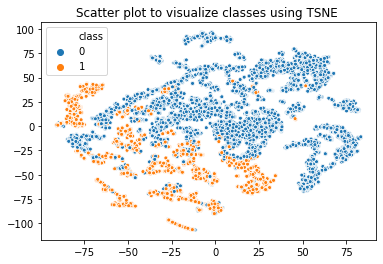

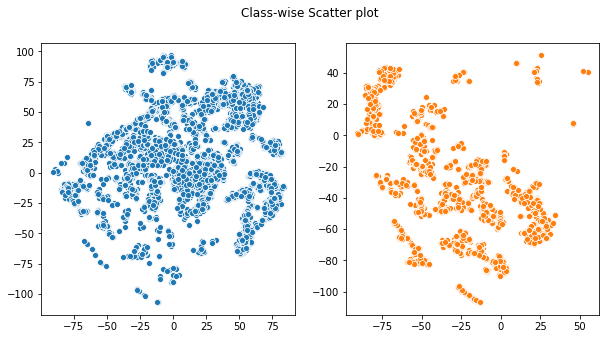

In [57]:
#####-----Scatter plot to visualize Data using TSNE ----#####
from sklearn.manifold import TSNE
data_for_plot = train_df.sample(10000)
data_for_plot_x = data_for_plot.drop("class", axis = 1).copy()
data_for_plot_y = data_for_plot["class"].copy()

train_df_embedded = TSNE(n_components=2, perplexity=30).fit_transform(data_for_plot_x)

sns.scatterplot(train_df_embedded[:,0],train_df_embedded[:,1],
                hue = data_for_plot_y, s = 15)
plt.title("Scatter plot to visualize classes using TSNE ")
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.scatterplot(train_df_embedded[data_for_plot_y.values==0,0],
                train_df_embedded[data_for_plot_y.values==0,1],
                ax = axes[0],
                color = "C0"
               )
sns.scatterplot(train_df_embedded[data_for_plot_y.values==1,0],
                train_df_embedded[data_for_plot_y.values==1,1],
                ax = axes[1],
                color ="C1"
               )
plt.suptitle("Class-wise Scatter plot ")
plt.show()

## 2 . Feature Selection
### 2.1 Selecting top 75% features using Mutual Information

In [4]:
# import the required functions and object.
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# select the number of features you want to retain.
select_k = 80 # 75% features
import random
random.seed(0)
idx = random.sample(range(train_df.shape[0]),10000)
x_train = train_df.drop("class", axis = 1, inplace = False)
y_train = train_df["class"]
# mi = mutual_info_classif(x_train, y_train)
selection = SelectKBest(mutual_info_classif, k=select_k).fit(x_train.iloc[idx], y_train.iloc[idx])


In [5]:
top_features = x_train.columns[selection.get_support()]

x_train = train_df[top_features].copy()
y_train = train_df["class"].copy()

x_test= test_df[top_features].copy()
y_test = test_df["class"].copy()

In [6]:
print("Top 5 features based on mutual information are ",list(top_features[0:5]))

Top 5 features based on mutual information are  ['ac_000', 'ad_000', 'ai_000', 'aj_000', 'al_000']


## 3. Model Evaluation
### 3.1 Functions
#### 3.1.1 Util functions

In [7]:
#####------Funtion to calculate loss give prediction and actual-----#####
def calculate_cost(y_true, y_pred, print_ = False):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred).ravel()
    cm = pd.DataFrame(cm.reshape((1,4)), columns=['tn', 'fp', 'fn', 'tp'])
    if print_:
        display(cm)
    total_cost = 10*cm.fp + 500*cm.fn
    return(total_cost)

######----- Function to plot confusion matrix and related metrices-----#####
def plot_confusion_mat(y_true, y_pred):
    from sklearn.metrics import confusion_matrix, accuracy_score
    cnf_mat = confusion_matrix(y_true, y_pred)
    labels= ["True Negative", "False Positive", "False Negative", "True Positive"]
    count = ["{0:0.0f}".format(value) for value in cnf_mat.flatten() ]
#     final_labels = [val1+"\n"+"{}".format(val2) for val1, val2 in zip(labels, count)]

#     sns.heatmap(cnf_mat,annot  = np.array(final_labels).reshape(2,2) ,fmt='', cmap='Blues')
#     plt.title("Confusion matrix")
#     plt.xlabel("Predicted condition")
#     plt.ylabel("True condition")
#     plt.show()
    rcall_mat = cnf_mat/ (cnf_mat.sum(axis =1).reshape(-1,1))

    labels= ["True Negative Rate", "False Positive Rate", "False Negative Rate", "True Positive Rate"]
    percentage = ["{0:.2%}".format(value) for value in rcall_mat.flatten()]
    final_labels = [val1+"\n"+"{}".format(val3)+"({})".format(val2) for val1, val2, val3 in zip(labels, count, percentage)]

    sns.heatmap(rcall_mat,annot  = np.array(final_labels).reshape(2,2),fmt='',  cmap='Reds', annot_kws={"size": 12})
    plt.xlabel("Predicted condition")
    plt.ylabel("True condition")
    plt.show()

#### 3.1.2  Function for evaluating ML models for building classifier

In [8]:
#####----- Crating a custom score object for cross validation-----#####
from sklearn.metrics import make_scorer
score = make_scorer(calculate_cost, greater_is_better=False)## Custom scorer

In [9]:
#####-----Function for classifier selection -----#####

def train_classifier(x, y, classifier):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.svm import SVC
    from sklearn.linear_model import SGDClassifier
    from sklearn.tree import DecisionTreeClassifier
    
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    global score
    weights= [(1,5000), (1,1000), (1,500), (1,100), (1,10), 
              (5000,1), (1000,1), (500,1), (100,1), (10,1), (1,1)]
    
##########---------- 1. LOGISTIC REGRESSION----------##########   

    if classifier == "logistic":
        grid = {"l1_ratio": [0.1, 0.5, 0.7],
                "alpha": [10**val for val in np.arange(-4,4, dtype=float) ],        
                "class_weight": [{0: x[0], 1: x[1]} for x in weights]
               }
        clf = SGDClassifier(loss ="log" , n_jobs = 4, random_state=0, penalty = "elasticnet")

##########---------- 2. LINEAR SVM----------##########

    if classifier == "linsvm":
        grid = {"l1_ratio": [0.1, 0.5, 0.7],
                "alpha": [10**val for val in np.arange(-4,4, dtype=float) ],        
                "class_weight": [{0: x[0], 1: x[1]} for x in weights]            
               }
        clf = SGDClassifier(loss ="hinge" , n_jobs = 4, random_state=0, penalty = "elasticnet")
        
    
##########---------- 3. SVM----------##########

    if classifier == "SVM":
        grid = {"C":[10**val for val in np.arange(-3,3, dtype=float)], 
                "class_weight": [{0: x[0], 1: x[1]} for x in weights]  
               }
        clf = SVC(random_state =0)

        
##########----------4. DECISION TREE ----------##########

    if classifier == "Decision_tree":
        grid = {"criterion":["gini", "entropy"], 
                "max_depth": [20,50,100,200,None],
                "min_samples_split": [2,10,20,50],
                "min_samples_leaf": [1,5,10,25],
                "class_weight": [{0: x[0], 1: x[1]} for x in weights]
               }
        clf = DecisionTreeClassifier( random_state = 0)
        
##########----------5. RANDOM FOREST ----------##########

    if classifier == "Random_forest":
        grid = {"n_estimators":[100,500, 1000],
                "class_weight": [{0: x[0], 1: x[1]} for x in weights]
               }
        clf = RandomForestClassifier(n_jobs = 4, random_state=0)

        
    Grid_cv = GridSearchCV(estimator=clf,
                           param_grid= grid,
                           scoring= score,
                           cv=3, 
                           n_jobs=4, 
                           verbose= 0
                          )
    Grid_cv.fit(x, y)
    return(Grid_cv)


### 3.2. Train and compare models
#### Standardizing data before training models

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [11]:
## Selecting random 20k sample for faster crossvalidation
idx = random.sample(range(x_train.shape[0]),20000)
x_train_scaled_sampled = x_train_scaled[idx].copy()
y_train_sampled = y_train[idx].copy()

#### 3.2.1. Logistic Rgression

In [66]:
CV_log = train_classifier(x = x_train_scaled_sampled, y= y_train_sampled, classifier="logistic")

In [67]:

print("Loss on train data\n: ", calculate_cost(y_pred=CV_log.best_estimator_.predict(x_train_scaled), y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred=CV_log.best_estimator_.predict(x_train_scaled), y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred=CV_log.best_estimator_.predict(x_test_scaled), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred=CV_log.best_estimator_.predict(x_test_scaled), y_true= y_test) )


,tn,fp,fn,tp
0,45180,13820,0,25048


Loss on train data
:  [138200]
F1 score on train data
:  0.7837787095562927


,tn,fp,fn,tp
0,12072,3553,6,369


Loss on test data
:  [38530]
F1 score on test data
:  0.17174773097509888


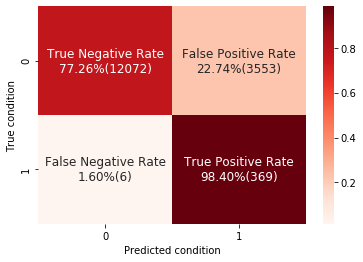

In [68]:
plot_confusion_mat(y_pred=CV_log.best_estimator_.predict(x_test_scaled), y_true= y_test)

#### 3.2.2. Linear SVM

In [69]:
CV_linSVM = train_classifier(x = x_train_scaled_sampled, y= y_train_sampled, classifier="linsvm")

In [70]:
print("Loss on train data\n: ", calculate_cost(y_pred=CV_linSVM.best_estimator_.predict(x_train_scaled), y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred=CV_linSVM.best_estimator_.predict(x_train_scaled), y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred=CV_linSVM.best_estimator_.predict(x_test_scaled), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred=CV_linSVM.best_estimator_.predict(x_test_scaled), y_true= y_test) )


,tn,fp,fn,tp
0,50168,8832,34,25014


Loss on train data
:  [105320]
F1 score on train data
:  0.8494583488980201


,tn,fp,fn,tp
0,13369,2256,8,367


Loss on test data
:  [26560]
F1 score on test data
:  0.24482988659106075


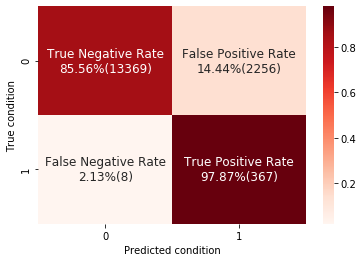

In [71]:
plot_confusion_mat(y_pred=CV_linSVM.best_estimator_.predict(x_test_scaled), y_true= y_test)

#### 3.2.3. SVM with RBF Kernel

In [72]:
CV_SVC = train_classifier(x = x_train_scaled_sampled, y= y_train_sampled, classifier="SVM")

In [73]:
print("Loss on train data\n: ", calculate_cost(y_pred=CV_SVC.best_estimator_.predict(x_train_scaled), y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred=CV_SVC.best_estimator_.predict(x_train_scaled), y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred=CV_SVC.best_estimator_.predict(x_test_scaled), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred=CV_SVC.best_estimator_.predict(x_test_scaled), y_true= y_test) )


,tn,fp,fn,tp
0,55407,3593,16,25032


Loss on train data
:  [43930]
F1 score on train data
:  0.9327594880107317


,tn,fp,fn,tp
0,14677,948,32,343


Loss on test data
:  [25480]
F1 score on test data
:  0.4117647058823529


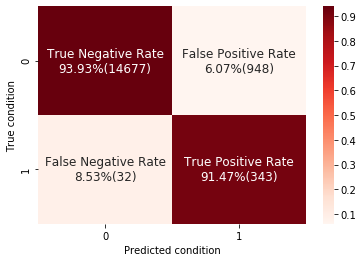

In [74]:
plot_confusion_mat(y_pred=CV_SVC.best_estimator_.predict(x_test_scaled), y_true= y_test)

#### 3.2.4. Decision Tree

In [75]:
CV_DT = train_classifier(x = x_train_scaled_sampled, y= y_train_sampled, classifier="Decision_tree")

In [76]:
print("Loss on train data\n: ", calculate_cost(y_pred=CV_DT.best_estimator_.predict(x_train_scaled), y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred=CV_DT.best_estimator_.predict(x_train_scaled), y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred=CV_DT.best_estimator_.predict(x_test_scaled), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred=CV_DT.best_estimator_.predict(x_test_scaled), y_true= y_test) )


,tn,fp,fn,tp
0,56441,2559,83,24965


Loss on train data
:  [67090]
F1 score on train data
:  0.9497451114661797


,tn,fp,fn,tp
0,14936,689,11,364


Loss on test data
:  [12390]
F1 score on test data
:  0.5098039215686275


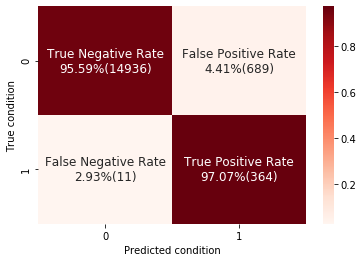

In [80]:
plot_confusion_mat(y_pred=CV_DT.best_estimator_.predict(x_test_scaled), y_true= y_test)

#### 3.2.5. Random Forest

In [15]:
CV_RF = train_classifier(x = x_train_scaled_sampled, y= y_train_sampled, classifier="Random_forest")

Fitting 3 folds for each of 33 candidates, totalling 99 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.9min
[Parallel(n_jobs=4)]: Done  99 out of  99 | elapsed: 32.7min finished


In [16]:
print("Loss on train data\n: ", calculate_cost(y_pred=CV_RF.best_estimator_.predict(x_train_scaled), y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred=CV_RF.best_estimator_.predict(x_train_scaled), y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred=CV_RF.best_estimator_.predict(x_test_scaled), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred=CV_RF.best_estimator_.predict(x_test_scaled), y_true= y_test) )


,tn,fp,fn,tp
0,58713,287,55,24993


Loss on train data
:  [30370]
F1 score on train data
:  0.9932045779685265


,tn,fp,fn,tp
0,15529,96,12,363


Loss on test data
:  [6960]
F1 score on test data
:  0.8705035971223022


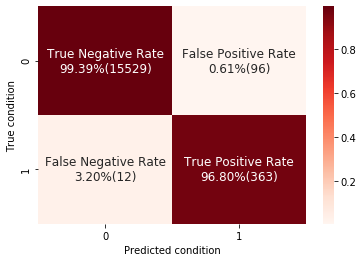

In [18]:
plot_confusion_mat(y_pred=CV_RF.best_estimator_.predict(x_test_scaled), y_true= y_test)

### 3.2.6 Comparison 

| Algorithm | Train Loss | Train F1 Score | Test Loss | Test F1 Score |
| --- | --- | --- |--- | --- | 
| Logistic regression | 138200 | 0.784 | 38530 | 0.171|
| Linear SVM | 105320 | 0.849 | 26560 | 0.245|
| SVM with RBF kernel| 43930 | 0.933 | 25480 | 0.411|
| Decision Tree| 67090 | 0.950 | 12390 | 0.51|
| Random Forest| 30370 | 0.993 | 6960 | 0.870|

    From above table we can conclude that
        1. Over all linear classifiers that is logistic regression and linear SVM have poor performance.
        2. SVM with RBF kernel has better performance compared to linear methods, however if we compare test and train scores, we can observe overfitting. Though the obtained result for SVM with RBF kernel is after hyperparameter tuning, overfitting issue can still be addressed. However further hyperparameter tuning may not improve test loss (most likely). 
        3.Compared to SVM decision tree performance is better with relatively leaser overfitting.
        4. Random forest algorithm outperforms all above algorithms with best performance and almost no overfitting
        5. It was also observed that SVM was the slowest to train due to large sample size(O(n^3))
        Based on above analysis Random Forest algorithm has been selected for building classifier on entire training data
**Above analysis on performance has been obtained on 20K points randomly sampled from training data   

## 4. Training a classifier using Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators= 700,class_weight={0:1500,1:1},random_state=0,  n_jobs=4)
RF_clf.fit(x_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1500, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=700, n_jobs=4, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [28]:
y_pred_tr = RF_clf.predict(x_train_scaled)
y_pred_te = RF_clf.predict(x_test_scaled)

In [29]:
print("Loss on train data\n: ", calculate_cost(y_pred = y_pred_tr, y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred = y_pred_tr, y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred = y_pred_te, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = y_pred_te, y_true= y_test) )


,tn,fp,fn,tp
0,59000,0,0,25004


Loss on train data
:  [0]
F1 score on train data
:  1.0


,tn,fp,fn,tp
0,15564,61,17,358


Loss on test data
:  [9110]
F1 score on test data
:  0.9017632241813602


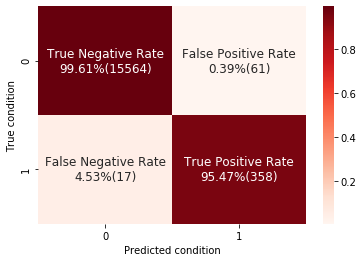

In [30]:
plot_confusion_mat(y_pred= y_pred_te, y_true= y_test)

### 4.1. Distribution plot of predicted probability 
    This plot is to identify if there is an overlap between class-wise distributions of predicted probability for test data 

In [31]:
prob_df =pd.DataFrame({"actual":y_test,
                       "prediction": y_pred_te, 
                       "prob": RF_clf.predict_proba(x_test_scaled)[:,1],
                      })

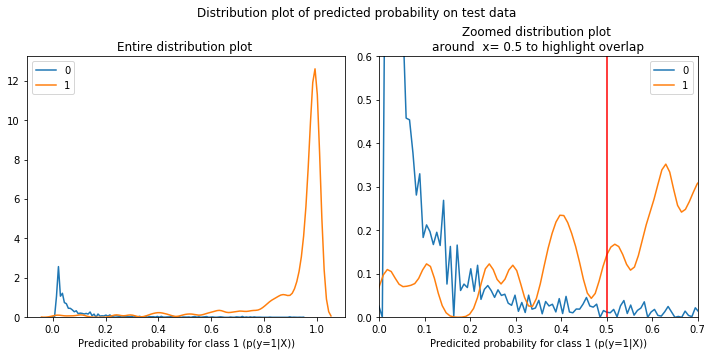

In [32]:
## elipse around x= 0.4
x= np.arange(0.28,0.521, 0.001)
y1 = 5*np.sqrt(np.round(0.0144-(x-0.4)**2, 4))
y2 = y1*(-1)
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.kdeplot(prob_df.loc[prob_df["actual"] ==0, "prob"], label = "0", ax= axes[0])
sns.kdeplot(prob_df.loc[prob_df["actual"] ==1, "prob"], label ="1", ax= axes[0])
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.kdeplot(prob_df.loc[prob_df["actual"] ==0, "prob"], label = "0", ax= axes[1])
sns.kdeplot(prob_df.loc[prob_df["actual"] ==1, "prob"], label ="1", ax= axes[1])
plt.plot([0.5,0.5], [0,0.6],  color='red') ## A vertical line to show default threshold for class assignment
axes[1].set_xlim(0,0.7)
axes[1].set_ylim(0,0.6)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

    From the above distribution plots following are the observations
        1. Predicted probability p(y=1|X) for most of the samples belonging to negative class(y=0) is less than 0.5.  Similarly for samples belonging to positive class predicted probability is greater than 0.5. With the default threshold of 0.5(vertical line) for class assignment these samples will be correctly classified
        2. However there are samples from negative class with predicted probability p(y=1|X) greater than =0.5. Similarly there are few samples belonging to positive class(y=1) with predicted probability <0.5. 
    Samples from point 2 will be misclassified as either false negative (FN) or false Positive(FP). Since in this problem loss weightage for FN is 50 times more than that of FP, changing probability threshold to reduce number of FNs at the cost of higher number of FPs may further reduce test loss. This idea will be examined in below section. 
    
    
    To evaluate impact of changing probability threshold K fold cross validation approach has been adapted. A threshold range of 0.1 to 0.7 has been selected. For each threshold value 5 fold CV is performed. 
        i.	In each CV iteration actual training data is divided into train and CV dataset. 
        ii.	A classifier is trained using  the new training data obtained after step ii and loss is calculated using CV data. 
        iii.	After end of 5 CV iterations mean of 5 CV losses are taken as average loss occurred with corresponding probability threshold. 
 


## 5. Improving trained classifier by changing probability threshold
### 5.1. Kfold Cv to obtain best threshold value

In [33]:
## Selecting random 20k sample for faster crossvalidation
idx = random.sample(range(x_train.shape[0]),30000)
x_train_scaled_sampled = x_train_scaled[idx].copy()
y_train_sampled = y_train[idx].copy().values

In [34]:
from tqdm import tqdm
k_folds = 5

cv_size = x_train_scaled_sampled.shape[0]//k_folds
thresholds = np.arange(0.1,0.8,0.1)
K_fold_loss =[]
for threshold in tqdm(thresholds):
    loss =0
    start_idx  =0
    for k in range(k_folds):
        end_idx = start_idx+cv_size
        cv_idx = random.sample(range(x_train_scaled_sampled.shape[0]), cv_size)
        train_idx = [x for x in  np.arange(x_train_scaled_sampled.shape[0]) if x not in cv_idx]
        ###---Spliting Data ---###
        X_cv = x_train_scaled_sampled[cv_idx].copy()
        y_cv = y_train_sampled[cv_idx].copy()

        x_tr = x_train_scaled_sampled[train_idx].copy()
        y_tr = y_train_sampled[train_idx].copy()
        
        ###--- Model---###
        RF_clf = RandomForestClassifier(n_estimators= 500,class_weight={0:500,1:1},random_state=0,  n_jobs=4)
        RF_clf.fit(x_tr, y_tr)
        
        ###---Prediction based on threshiold---###
        pred = np.zeros(cv_size)
        prob = RF_clf.predict_proba(X_cv)[:,1]
        pred[prob>threshold] =1
        print(loss, calculate_cost(y_pred = pred, y_true= y_cv) .values)
        loss += calculate_cost(y_pred = pred, y_true= y_cv) .values
        start_idx = end_idx
    print(loss)
    K_fold_loss.extend(loss/k_folds)
    print(K_fold_loss)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

0 [2570]
[2570] [2490]
[5060] [2360]
[7420] [2330]


 14%|███████████▊                                                                       | 1/7 [06:12<37:15, 372.55s/it]

[9750] [2560]
[12310]
[2462.0]
0 [1380]
[1380] [1260]
[2640] [1530]
[4170] [2030]


 29%|███████████████████████▋                                                           | 2/7 [10:21<27:56, 335.38s/it]

[6200] [1410]
[7610]
[2462.0, 1522.0]
0 [3010]
[3010] [1110]
[4120] [1280]
[5400] [1790]


 43%|███████████████████████████████████▌                                               | 3/7 [14:39<20:49, 312.35s/it]

[7190] [810]
[8000]
[2462.0, 1522.0, 1600.0]
0 [1050]
[1050] [1920]
[2970] [1630]
[4600] [3450]


 57%|███████████████████████████████████████████████▍                                   | 4/7 [19:34<15:21, 307.19s/it]

[8050] [1630]
[9680]
[2462.0, 1522.0, 1600.0, 1936.0]
0 [2380]
[2380] [3000]
[5380] [890]
[6270] [2910]


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [24:31<10:07, 303.93s/it]

[9180] [1460]
[10640]
[2462.0, 1522.0, 1600.0, 1936.0, 2128.0]
0 [4760]
[4760] [4210]
[8970] [3860]
[12830] [4720]


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [28:53<04:51, 291.35s/it]

[17550] [4230]
[21780]
[2462.0, 1522.0, 1600.0, 1936.0, 2128.0, 4356.0]
0 [7070]
[7070] [8630]
[15700] [6690]
[22390] [8670]


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [33:08<00:00, 284.05s/it]

[31060] [4650]
[35710]
[2462.0, 1522.0, 1600.0, 1936.0, 2128.0, 4356.0, 7142.0]


#### 5.1.1.  Plot of average CV loss vs corrresponding probability threshold

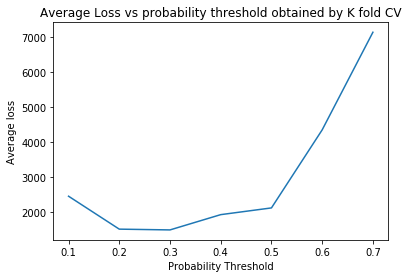

,Thresholds,Average CV Loss
0,0.1,2462.0
1,0.2,1522.0
2,0.3,1500.0
3,0.4,1936.0
4,0.5,2128.0
5,0.6,4356.0
6,0.7,7142.0


In [43]:
plt.plot(thresholds, K_fold_loss)
plt.xlabel("Probability Threshold")
plt.ylabel("Average loss")
plt.title("Average Loss vs probability threshold obtained by K fold CV")
plt.show()

display(pd.DataFrame (dict({"Thresholds": thresholds,
                            "Average CV Loss": K_fold_loss   }
                          )))

     1. As explained earlier by changing probability threshold lower CV loss has changed. 
     2. For probability threshold of 0.3 average CV loss is lowest followed by 0.2. The difference is marginal
     3. As we move towards leftor right from 0.3 or we can observe a rapid increase in average CV loss values. 

    From these observation we can conclude that instead of using the default threshold of 0.5 it is better to reduce it. Note this is working as FN has 50 times more weightage  compared to FP in loss calculation. 

    The selected probability threshold is 0.3
        prediction = 0 if P(y=1|X) < 0.3
                     1 otherwise


### 5.2 Model evaluation with probability threshold = 0.3

,tn,fp,fn,tp
0,15315,310,5,370


Loss on test data
:  [5600]
F1 score on test data
:  0.7014218009478673
ROC-AUC score on test data
:  0.9983463253333333


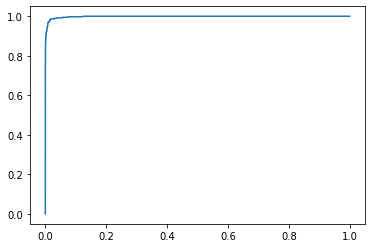

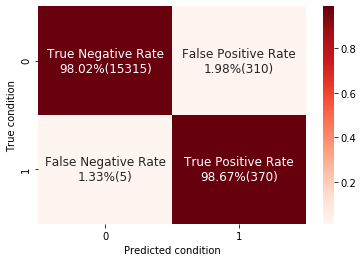

In [36]:
new_y_pred = np.zeros(x_test_scaled.shape[0])
new_y_pred[RF_clf.predict_proba(x_test_scaled)[:,1] >=0.3] =1 

print("Loss on test data\n: ", calculate_cost(y_pred = new_y_pred, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = new_y_pred, y_true= y_test) )
print("ROC-AUC score on test data\n: ", roc_auc_score(y_score = RF_clf.predict_proba(x_test_scaled)[:,1],
                                                      y_true= y_test) )



fpr, tpr , thresholds= roc_curve( y_score = RF_clf.predict_proba(x_test_scaled)[:,1],
                                 y_true= y_test)
plt.plot(fpr, tpr)
plt.show()

plot_confusion_mat(y_pred=new_y_pred, y_true= y_test)

### 5.3 Observations

| Probability Threshold | Loss |  F1 Score | False Negative | FNR | False Positive | FPR |
| --- | --- | --- |--- | --- | --- | --- | 
| 0.5 (Default) | 9100 | 0.902 | 17 | 4.53%| 60 | 0.38%|
| 0.3 | 4890 | 0.834 | 7 | 1.87%| 139 | 0.89%|


    1. From the above test scoe obtained, impact of threshold change is apprent. By changing probability threshold from 0.5 to 0.3, test loss reduced from 9100 to 4890. This happened as number of FN reduced from 17(4.53%) to 7 (1.8%). However the F1 Score decreased from 0.902 to 0.834. This happened as FP incresed from 60(0.38%) to 139(0.89%).
    2. We could achieve((9100-4890)/9100) 46%  improvement in test loss by changing probability threshold from 0.5 to 0.3 with a 7% reduction in overall F1 Score.  


## 6.Some more Ensemble model please

    As shown earlier the classifier using Random forest(RF) algorithm outperformed all other classical algorithms. RF is an ensemble model and therefore few more ensemble models should be evaluated. In the following section we will evaluate 
    1. Boosting based ensemble model (GBDT)
    2. Stacking
### 6.1. GBDT


In [21]:
import  xgboost as xgb
from sklearn.model_selection import GridSearchCV
data_dmatrix = xgb.DMatrix(data=x_train_scaled,label=y_train)

###---Hyperparameter tunning---###
params = {'n_estimators': [50, 100, 150, 200],
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'max_depth': range(3, 10),
          'colsample_bytree': [i/10.0 for i in range(1, 3)],
          'gamma': [i/10.0 for i in range(3)],
          'reg_lambda ': [i/10.0 for i in range(3)]
         }

clf_GBDT = xgb.XGBRFClassifier(objective ='binary:logistic', random_state  = 0)
# Define grid search
Grid_cv_GBDT = GridSearchCV(clf_GBDT,
                            param_grid=params,
                            cv=3,
                            scoring=score,
                            verbose=1,
                            n_jobs=-4
                           )
Grid_cv_GBDT.fit(x_train_scaled_sampled, y_train_sampled)

Fitting 3 folds for each of 2016 candidates, totalling 6048 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  40 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-4)]: Done 190 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-4)]: Done 440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-4)]: Done 790 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-4)]: Done 1240 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-4)]: Done 1790 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-4)]: Done 2440 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-4)]: Done 3190 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-4)]: Done 4040 tasks      | elapsed: 42.6min
[Parallel(n_jobs=-4)]: Done 4990 tasks      | elapsed: 59.2min
[Parallel(n_jobs=-4)]: Done 6048 out of 6048 | elapsed: 79.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRFClassifier(base_score=0.5, colsample_bylevel=1,
                                       colsample_bynode=0.8, colsample_bytree=1,
                                       gamma=0, learning_rate=1,
                                       max_delta_step=0, max_depth=3,
                                       min_child_weight=1, missing=None,
                                       n_estimators=100, n_jobs=1, nthread=None,
                                       objective='binary:logistic',
                                       random_state=0, reg_alpha=0,
                                       reg_lambda=1, scale_pos_weight=1,
                                       seed...
                                       verbosity=1),
             iid='deprecated', n_jobs=-4,
             param_grid={'colsample_bytree': [0.1, 0.2],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2, 

In [22]:
Grid_cv_GBDT.best_estimator_

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=0.2, gamma=0.0, learning_rate=0.01,
                max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
                n_estimators=50, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, reg_lambda =0.0, scale_pos_weight=1, seed=None,
                silent=None, subsample=0.8, verbosity=1)

In [23]:
# import pickle
# (scaler2, RF_clf2, clf_GBDT,  clf_meta2 ) = pickle.load(open("ALL_model_data.pkl", 'rb')) 
# (base_clf_1_2, base_clf_2_2,base_clf_3_2, base_clf_4_2, Meta_clf_2) = clf_meta2

In [24]:
clf_GBDT = Grid_cv_GBDT.best_estimator_
clf_GBDT.fit(x_train_scaled_sampled, y_train_sampled)

y_pred_GBDT_tr = clf_GBDT.predict(x_train_scaled)
y_pred_GBDT_te = clf_GBDT.predict(x_test_scaled)

,tn,fp,fn,tp
0,58472,528,436,24568


Loss on train data
:  [223280]
F1 score on train data
:  0.9807584830339322


,tn,fp,fn,tp
0,15473,152,19,356


Loss on test data
:  [11020]
F1 score on test data
:  0.8063420158550396


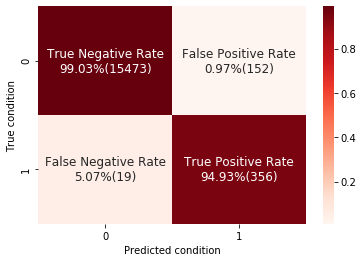

In [25]:
print("Loss on train data\n: ", calculate_cost(y_pred = y_pred_GBDT_tr, y_true= y_train, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred = y_pred_GBDT_tr, y_true= y_train) )

print("="*100)
print("Loss on test data\n: ", calculate_cost(y_pred = y_pred_GBDT_te, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = y_pred_GBDT_te, y_true= y_test) )


plot_confusion_mat(y_pred= y_pred_GBDT_te, y_true= y_test)

#### 6.1.1 Improving GBDT classifier performance by changing probability threshold

In [26]:
prob_df_GBDT =pd.DataFrame({"actual":y_test,
                       "prediction": y_pred_GBDT_te, 
                       "prob": clf_GBDT.predict_proba(x_test_scaled)[:,1],
                      })

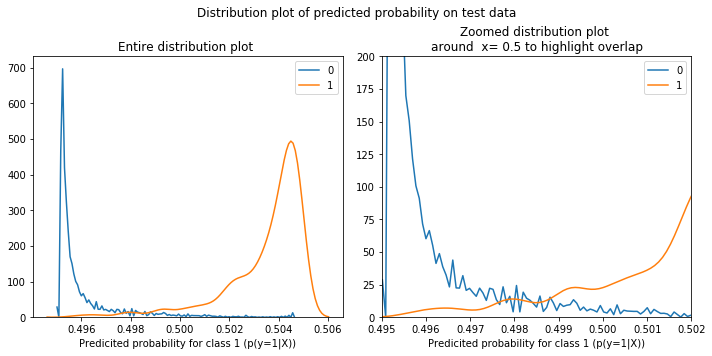

In [27]:


fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.kdeplot(prob_df_GBDT.loc[prob_df_GBDT["actual"] ==0, "prob"], label = "0", ax= axes[0])
sns.kdeplot(prob_df_GBDT.loc[prob_df_GBDT["actual"] ==1, "prob"], label ="1", ax= axes[0])
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.kdeplot(prob_df_GBDT.loc[prob_df_GBDT["actual"] ==0, "prob"], label = "0", ax= axes[1])
sns.kdeplot(prob_df_GBDT.loc[prob_df_GBDT["actual"] ==1, "prob"], label ="1", ax= axes[1])
# plt.plot([0.5,0.5], [0,0.6],  color='red') ## A vertical line to show default threshold for class assignment
axes[1].set_xlim(0.495,0.502)
axes[1].set_ylim(0,200)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

,tn,fp,fn,tp
0,15165,460,8,367


Loss on test data
:  [8600]
F1 score on test data
:  0.610648918469218
ROC-AUC score on test data
:  0.9977202346666667


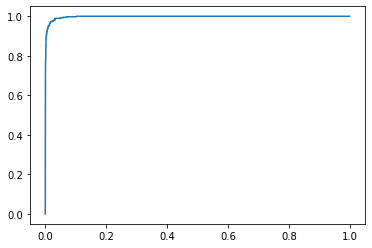

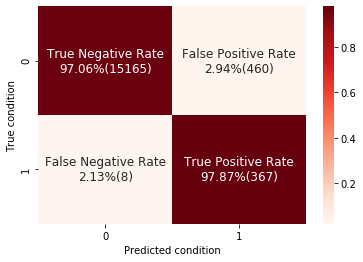

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

new_y_pred_GBDT = np.zeros(x_test_scaled.shape[0])
new_y_pred_GBDT[clf_GBDT.predict_proba(x_test_scaled)[:,1] >= 0.497] =1 

print("Loss on test data\n: ", calculate_cost(y_pred = new_y_pred_GBDT, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = new_y_pred_GBDT, y_true= y_test) )

print("ROC-AUC score on test data\n: ", roc_auc_score(y_score = clf_GBDT.predict_proba(x_test_scaled)[:,1],
                                                      y_true= y_test) )



fpr, tpr , thresholds= roc_curve( y_score = clf_GBDT.predict_proba(x_test_scaled)[:,1],
                                 y_true= y_test)
plt.plot(fpr, tpr)
plt.show()

plot_confusion_mat(y_pred= new_y_pred_GBDT, y_true= y_test)

#### 6.1.2 Observations

| Probability Threshold | Loss |  F1 Score |
| --- | --- | --- |
| 0.5 (Default) | 11020 | 0.80 |
| 0.497 | 8600 | 0.610|


    1. From the above test score obtained, impact of threshold change is apparent. However the reduction in loss is 28% unlike 46% in case of random forest.
    2. The PDFs of predicted probability for class 0 and class 1 are not very well separated and this model though produces low loss value not suitable if probability is of interest. In such cases an additional calibration model can be used.



## 6.2. Stacking based ensemble model

In [36]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



#####----- Creating data fro base classifiers and meta learner-----#####
x_tr_stack_D1, x_tr_stack_D2, y_tr_stack_D1, y_tr_stack_D2 = train_test_split(x_train_scaled, y_train.values,
                                                                               test_size =0.3,
                                                                               stratify = y_train
                                                                              )

#####----- Building 3 base classifiers -----#####

###---Spliting D1 dataset into three groups ---###

random.seed(0)
idx1 = random.sample(range(x_tr_stack_D1.shape[0]),40000)
idx2 = random.sample(range(x_tr_stack_D1.shape[0]),40000)
idx3 = random.sample(range(x_tr_stack_D1.shape[0]),40000)
idx4 = random.sample(range(x_tr_stack_D1.shape[0]),40000)

## data for first base classifier (KNN clasifier)
x_tr_stack_D11 = x_tr_stack_D1[idx1].copy()
y_tr_stack_D11 = y_tr_stack_D1[idx1].copy()

## data for second base classifier (SVM clasifier)
x_tr_stack_D12 = x_tr_stack_D1[idx2].copy()
y_tr_stack_D12 = y_tr_stack_D1[idx2].copy()

## data for third base classifier (DT clasifier)
x_tr_stack_D13 = x_tr_stack_D1[idx3].copy()
y_tr_stack_D13 = y_tr_stack_D1[idx3].copy()

## data for third base classifier (RF clasifier)
x_tr_stack_D14 = x_tr_stack_D1[idx4].copy()
y_tr_stack_D14 = y_tr_stack_D1[idx4].copy()

###--- Creating Base classifiers---###
base_clf_1 =   KNeighborsClassifier(weights= "distance",
                                    n_neighbors =7 )

base_clf_2 =  SVC(C =10, class_weight={0: 1, 1: 10}, probability=True)

base_clf_3 = DecisionTreeClassifier(class_weight=  {0: 1, 1: 100}, 
                                    max_depth = 20,
                                    min_samples_leaf = 25,
                                    min_samples_split = 2)  
base_clf_4 = RandomForestClassifier(n_estimators= 700,
                                    class_weight={0:1500,1:1}, 
                                    random_state=0, 
                                    n_jobs=4)

#####----- Training Base Classifier -----#####


base_clf_1.fit(x_tr_stack_D11, y_tr_stack_D11)
base_clf_2.fit(x_tr_stack_D12, y_tr_stack_D12)
base_clf_3.fit(x_tr_stack_D13, y_tr_stack_D13)
base_clf_4.fit(x_tr_stack_D14, y_tr_stack_D14)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 1500, 1: 1}, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=700, n_jobs=4, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [37]:

## we will take predicted probability of base learners as X 

X_tr_base_clf_1 = base_clf_1.predict_proba(x_tr_stack_D2)
X_tr_base_clf_2 = base_clf_2.predict_proba(x_tr_stack_D2)
X_tr_base_clf_3 = base_clf_3.predict_proba(x_tr_stack_D2)
X_tr_base_clf_4 = base_clf_4.predict_proba(x_tr_stack_D2)

x_tr_meta= np.vstack([X_tr_base_clf_1[:,1],
                      X_tr_base_clf_2[:,1],
                      X_tr_base_clf_3[:,1],
                      X_tr_base_clf_4[:,1]]
                    ).T



In [38]:

# Meta_clf = SVC(C = 100,
#                class_weight={0: 1, 1: 60},
#                gamma = 0.05,
#                probability= True,
#                random_state=0
#               )
Meta_clf = LogisticRegression(class_weight={0: 1, 1: 100})


Meta_clf.fit(x_tr_meta, y_tr_stack_D2)


LogisticRegression(C=1.0, class_weight={0: 1, 1: 100}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
print("Loss on train data\n: ", calculate_cost(y_pred = Meta_clf.predict(x_tr_meta), y_true= y_tr_stack_D2, print_=True) .values)
print("F1 score on train data\n: ", f1_score(y_pred = Meta_clf.predict(x_tr_meta), y_true= y_tr_stack_D2) )



,tn,fp,fn,tp
0,17601,99,0,7515


Loss on train data
:  [990]
F1 score on train data
:  0.9934562760261749


,tn,fp,fn,tp
0,15540,85,20,355


Loss on test data
:  [10850]
F1 score on test data
:  0.871165644171779


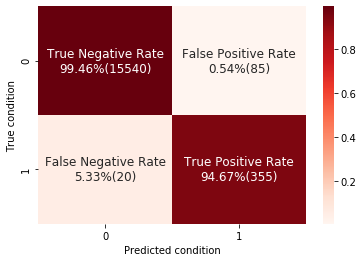

In [40]:
X_te_base_clf_1 = base_clf_1.predict_proba(x_test_scaled)
X_te_base_clf_2 = base_clf_2.predict_proba(x_test_scaled)
X_te_base_clf_3 = base_clf_3.predict_proba(x_test_scaled)
X_te_base_clf_4 = base_clf_4.predict_proba(x_test_scaled)

x_te_meta= np.vstack([X_te_base_clf_1[:,1],
                      X_te_base_clf_2[:,1],
                      X_te_base_clf_3[:,1],
                      X_te_base_clf_4[:,1]]
                    ).T


print("Loss on test data\n: ", calculate_cost(y_pred = Meta_clf.predict(x_te_meta), y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = Meta_clf.predict(x_te_meta), y_true= y_test) )


plot_confusion_mat(y_pred= Meta_clf.predict(x_te_meta), y_true= y_test)

In [41]:
prob =Meta_clf.predict_proba(x_te_meta)[:,1]
prob_df_stack =pd.DataFrame({"actual":y_test,
                       "prediction": Meta_clf.predict(x_te_meta), 
                       "prob": prob
                      })

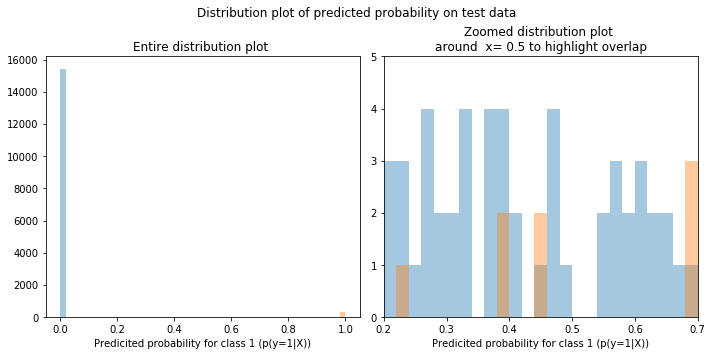

In [42]:




## elipse around x= 0.4

fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.distplot(prob_df_stack.loc[prob_df_stack["actual"] ==0, "prob"],
            label = "0", ax= axes[0],
            kde =False)
sns.distplot(prob_df_stack.loc[prob_df_stack["actual"] ==1, "prob"],
            label ="1", ax= axes[0], 
            kde =False)
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.distplot(prob_df_stack.loc[prob_df_stack["actual"] ==0, "prob"], 
            label = "0", ax= axes[1],
            kde =False)

sns.distplot(prob_df_stack.loc[prob_df_stack["actual"] ==1, "prob"],
            label ="1", ax= axes[1], 
           kde =False)
# plt.plot([0.5,0.5], [0,0.6],  color='red') ## A vertical line to show default threshold for class assignment
axes[1].set_xlim(0.2,0.7)
axes[1].set_ylim(0,5)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

#### 6.2.1 Improving Stacking classifier performance by changing probability threshold

,tn,fp,fn,tp
0,15505,120,15,360


Loss on test data
:  [8700]
F1 score on test data
:  0.8421052631578947
ROC-AUC score on test data
:  0.9980404053333334


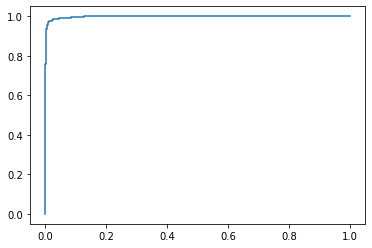

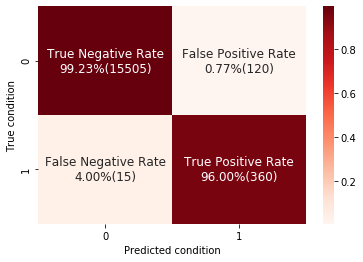

In [70]:
new_y_pred_stack = np.zeros(x_test_scaled.shape[0])
new_y_pred_stack[prob >= 0.2] =1 

print("Loss on test data\n: ", calculate_cost(y_pred = new_y_pred_stack, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = new_y_pred_stack, y_true= y_test) )
print("ROC-AUC score on test data\n: ", roc_auc_score(y_score = prob, y_true= y_test) )



fpr, tpr , thresholds= roc_curve( y_score = prob, y_true= y_test)
plt.plot(fpr, tpr)
plt.show()

plot_confusion_mat(y_pred= new_y_pred_stack, y_true= y_test)

#### 6.2.2 Observations
    Just like Random forest and GBDT loss of stacking based ensemble technique reduced by changing probability threshold from 10850 to 8700 (20%). This is not a lot compared to improvement in random forest approach. 
    However this model has better classification power than GBDT as predicted probability for class 0 abd 1 are well separated.

## 7. Deep Neural Network 

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(0)

### 7.1 Build Model

In [91]:
from tensorflow.keras.utils import to_categorical
y_train_encode = to_categorical(y_train)
y_test_encode = to_categorical(y_test)

In [103]:
 

clf_nn = Sequential()

clf_nn.add(Dense(16, input_shape = (x_train_scaled.shape[1], ), activation = "relu"))
clf_nn.add(Dropout(0.5))

clf_nn.add(BatchNormalization())
clf_nn.add(Dense(16, activation = "relu"))
clf_nn.add(Dropout(0.5))

clf_nn.add(Dense(2, activation = "sigmoid"))


In [104]:
ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
clf_nn.compile(loss='binary_crossentropy',
              optimizer=Adam(0.0002),
              metrics=['accuracy'])
clf_nn.fit(x_train_scaled, y_train_encode,
           class_weight = {0:0.1,1:1},
           batch_size=512,
           epochs= 250, 
           verbose=1,
           validation_data=(x_test_scaled, y_test_encode),
           callbacks= [ES]
          )

Train on 84048 samples, validate on 16000 samples
Epoch 1/250
84048/84048 [==============================] - 1s 13us/sample - loss: 0.2469 - accuracy: 0.5039 - val_loss: 0.7360 - val_accuracy: 0.4292
Epoch 2/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.1768 - accuracy: 0.5288 - val_loss: 0.8243 - val_accuracy: 0.4273
Epoch 3/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.1433 - accuracy: 0.5429 - val_loss: 0.8646 - val_accuracy: 0.4621
Epoch 4/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.1226 - accuracy: 0.5700 - val_loss: 0.8492 - val_accuracy: 0.5266
Epoch 5/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.1072 - accuracy: 0.6078 - val_loss: 0.8240 - val_accuracy: 0.5923
Epoch 6/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0944 - accuracy: 0.6624 - val_loss: 0.7948 - val_accuracy: 0.6655
Epoch 7/250
84048/84048 [==============================

84048/84048 [==============================] - 1s 7us/sample - loss: 0.0134 - accuracy: 0.9699 - val_loss: 0.0878 - val_accuracy: 0.9789
Epoch 110/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0138 - accuracy: 0.9697 - val_loss: 0.0880 - val_accuracy: 0.9792
Epoch 111/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0135 - accuracy: 0.9703 - val_loss: 0.0877 - val_accuracy: 0.9796
Epoch 112/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0133 - accuracy: 0.9711 - val_loss: 0.0894 - val_accuracy: 0.9793
Epoch 113/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0132 - accuracy: 0.9707 - val_loss: 0.0892 - val_accuracy: 0.9790
Epoch 114/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0131 - accuracy: 0.9705 - val_loss: 0.0886 - val_accuracy: 0.9797
Epoch 115/250
84048/84048 [==============================] - 1s 7us/sample - loss: 0.0137 - accuracy: 0.9698

,tn,fp,fn,tp
0,15349,276,29,346


Loss on test data
:  [17260]
F1 score on test data
:  0.6940822467402206


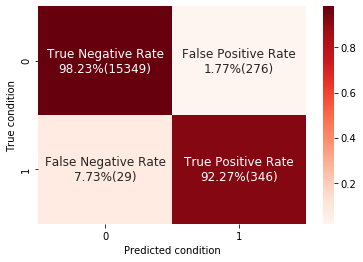

In [105]:
y_pred_nn = clf_nn.predict_classes(x_test_scaled)

print("Loss on test data\n: ", calculate_cost(y_pred = y_pred_nn, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = y_pred_nn, y_true= y_test) )

plot_confusion_mat(y_pred= y_pred_nn, y_true= y_test)

In [106]:
prob_df_nn =pd.DataFrame({"actual":y_test,
                       "prediction": y_pred_nn, 
                       "prob": clf_nn.predict(x_test_scaled)[:,1],
                      })


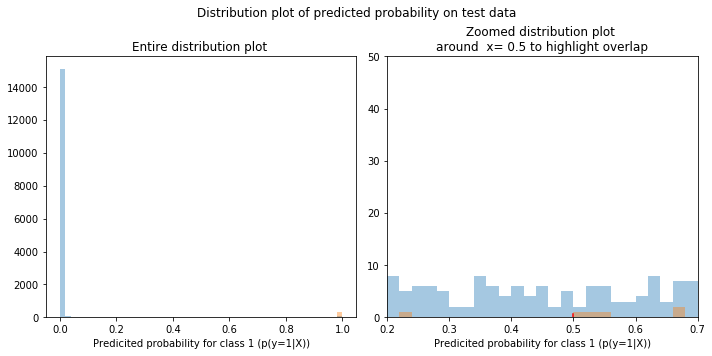

In [107]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
sns.distplot(prob_df_nn.loc[prob_df_nn["actual"] ==0, "prob"],
             label = "0", 
             ax= axes[0], 
             kde= False
            )

sns.distplot(prob_df_nn.loc[prob_df_nn["actual"] ==1, "prob"],
             label ="1",
             ax= axes[0], 
             kde= False
            )
axes[0].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[0].set_title("Entire distribution plot ")

sns.distplot(prob_df_nn.loc[prob_df_nn["actual"] ==0, "prob"],
             label = "0", 
             ax= axes[1], 
             kde= False
            )

sns.distplot(prob_df_nn.loc[prob_df_nn["actual"] ==1, "prob"],
             label ="1",
             ax= axes[1], 
             kde= False
            )

plt.plot([0.5,0.5], [0,0.6],  color='red') ## A vertical line to show default threshold for class assignment
axes[1].set_xlim(0.2 ,0.7)
axes[1].set_ylim(0,50)
axes[1].set_xlabel("Predicited probability for class 1 (p(y=1|X))")
axes[1].set_title("\nZoomed distribution plot \naround  x= 0.5 to highlight overlap")

fig.suptitle("Distribution plot of predicted probability on test data")
plt.tight_layout()

plt.show()

,tn,fp,fn,tp
0,15274,351,27,348


Loss on test data
:  [17010]
F1 score on test data
:  0.6480446927374303
ROC-AUC score on test data
:  0.9796097706666668


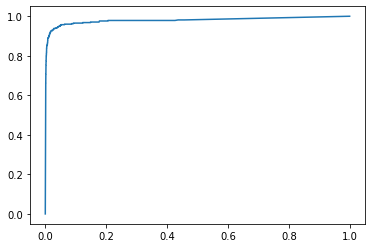

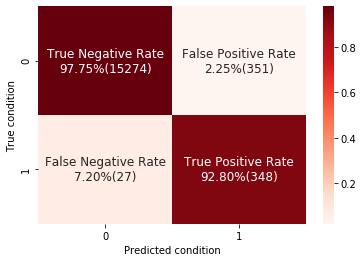

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score

new_y_pred_nn = np.zeros(x_test_scaled.shape[0])
new_y_pred_nn[clf_nn.predict(x_test_scaled)[:,1] >= 0.2] =1 

print("Loss on test data\n: ", calculate_cost(y_pred = new_y_pred_nn, y_true= y_test, print_=True).values)
print("F1 score on test data\n: ", f1_score(y_pred = new_y_pred_nn, y_true= y_test) )
print("ROC-AUC score on test data\n: ", roc_auc_score(y_score = clf_nn.predict(x_test_scaled)[:,1], y_true= y_test) )



fpr, tpr , thresholds= roc_curve( y_score = clf_nn.predict(x_test_scaled)[:,1], y_true= y_test.values)
plt.plot(fpr, tpr)
plt.show()

plot_confusion_mat(y_pred= new_y_pred_nn, y_true= y_test)


## 7. Conclusion
| Ensemble Method | loss |  F1 Score | ROC_AUC scoce|
| --- | --- | --- | --- |
| Random Forest | 4890 | 0.834 | 0.999 |
| GBDT | 8600 | 0.61 | 0.997 |
| Stacking | 8700 | 0.842 | 0.998 |
|Neural Network | 17010| 0.648 |0.980 |

    1. We can observe that both classes have overlapping regions from 2D scatter plot .
    2. After comparing multiple approached for training classifier Random forest was selected as it outperformed other algorithms.
    3.  From above test result we can conclude that RF has the best performance with minimum loss . It also has good separation between predicted probability for class 0 1nd 1. Performance of RF can be further improved by reducing probability threshold for class assignment.
    4. By changing probability threshold from 0.5 to 0.3, 46% reduction in cos was achieved. 
    5. Though GBDT has low loss value compared to stacking due to poor probability separation between class 0 and 1, an additional calibration model has to be used incase probbility is of intrest.
    6. The loss value obtained by neural network is significantly higher than ensmble methods.
